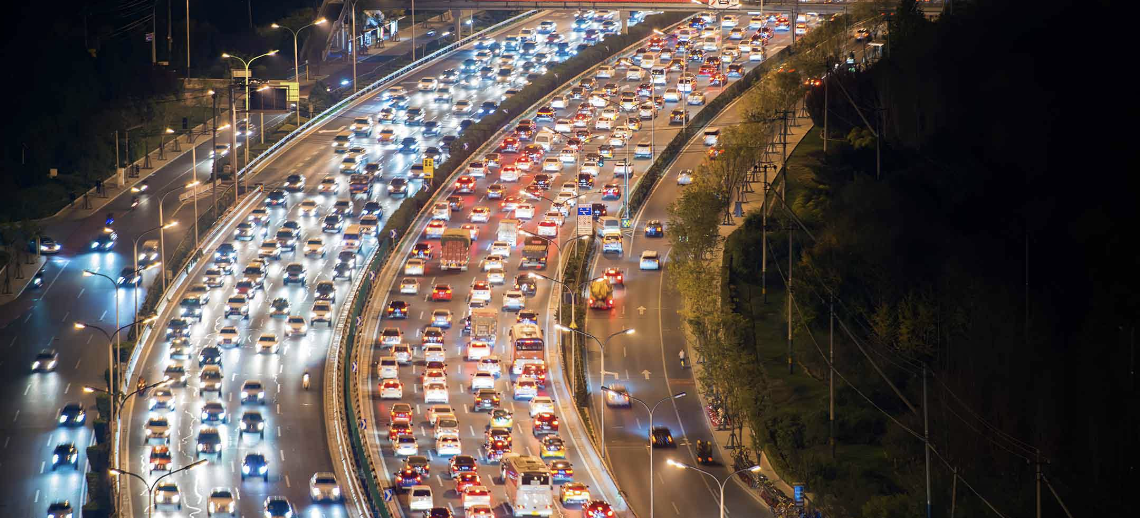

Traffic data fluctuates constantly or is affected by time. Predicting it can be challenging, but this task will help sharpen your time-series skills. With deep learning, you can use abstract patterns in data that can help boost predictability.

Your task is to build a system that can be applied to help you predict traffic volume or the number of vehicles passing at a specific point and time. Determining this can help reduce road congestion, support new designs for roads or intersections, improve safety, and more! Or, you can use to help plan your commute to avoid traffic!

The dataset provided contains the hourly traffic volume on an interstate highway in Minnesota, USA. It also includes weather features and holidays, which often impact traffic volume.

Time to predict some traffic!

### The data:

The dataset is collected and maintained by UCI Machine Learning Repository. The target variable is `traffic_volume`. The dataset contains the following and has already been normalized and saved into training and test sets:

`train_scaled.csv`, `test_scaled.csv`
| Column     | Type       | Description              |
|------------|------------|--------------------------|
|`temp`                   |Numeric            |Average temp in kelvin|
|`rain_1h`                |Numeric            |Amount in mm of rain that occurred in the hour|
|`snow_1h`                |Numeric            |Amount in mm of snow that occurred in the hour|
|`clouds_all`             |Numeric            |Percentage of cloud cover|
|`date_time`              |DateTime           |Hour of the data collected in local CST time|
|`holiday_` (11 columns)  |Categorical        |US National holidays plus regional holiday, Minnesota State Fair|
|`weather_main_` (11 columns)|Categorical     |Short textual description of the current weather|
|`weather_description_` (35 columns)|Categorical|Longer textual description of the current weather|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|
|`hour_of_day`|Numeric|The hour of the day|
|`day_of_week`|Numeric|The day of the week (0=Monday, Sunday=6)|
|`day_of_month`|Numeric|The day of the month|
|`month`|Numeric|The number of the month|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|

# How to approach the project
1. Prepare the data for modeling

2. Creating a neural network model

3. Training the model

4. Evaluating the model

In [1]:
# Import the relevant libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Read the traffic data from the CSV training and test files
train_scaled_df = pd.read_csv('train_scaled.csv')
test_scaled_df = pd.read_csv('test_scaled.csv')

# Convert the DataFrame to NumPy arrays
train_scaled = train_scaled_df.to_numpy()
test_scaled = test_scaled_df.to_numpy()

In [3]:
def summarize_dataframe(df):
    df_info = df.info()
    df_head = df.head()
    df_na_sum = df.isna().sum()
    return df_info, df_head, df_na_sum

train_info, train_head, train_na_sum = summarize_dataframe(train_scaled_df)
test_info, test_head, test_na_sum = summarize_dataframe(test_scaled_df)

# Display the first few records of the training and test dataframes
train_head, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34042 entries, 0 to 34041
Data columns (total 66 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   temp                                                     34042 non-null  float64
 1   rain_1h                                                  34042 non-null  float64
 2   snow_1h                                                  34042 non-null  float64
 3   clouds_all                                               34042 non-null  float64
 4   holiday_Christmas Day                                    34042 non-null  float64
 5   holiday_Columbus Day                                     34042 non-null  float64
 6   holiday_Independence Day                                 34042 non-null  float64
 7   holiday_Labor Day                                        34042 non-null  float64
 8   holiday_Martin Luther King

(       temp  rain_1h  snow_1h  ...  day_of_month     month  traffic_volume
 0  0.935245      0.0      0.0  ...      0.033333  0.818182        0.761676
 1  0.938749      0.0      0.0  ...      0.033333  0.818182        0.620330
 2  0.939463      0.0      0.0  ...      0.033333  0.818182        0.654808
 3  0.941247      0.0      0.0  ...      0.033333  0.818182        0.690385
 4  0.944524      0.0      0.0  ...      0.033333  0.818182        0.675549
 
 [5 rows x 66 columns],
        temp  rain_1h  snow_1h  ...  day_of_month  month  traffic_volume
 0  0.808980      0.0      0.0  ...           0.0    0.0        0.203022
 1  0.808072      0.0      0.0  ...           0.0    0.0        0.193407
 2  0.807358      0.0      0.0  ...           0.0    0.0        0.127885
 3  0.806904      0.0      0.0  ...           0.0    0.0        0.080357
 4  0.805963      0.0      0.0  ...           0.0    0.0        0.052335
 
 [5 rows x 66 columns])

## 1. Prepare the data for modeling
To model time-series data, you need to generate sequences of past values as inputs and predict the next value as the target. One way to do this is by writing a function and passing in the available data. These then need to be converted to `PyTorch` tensors and loaded.

In [4]:
# Write a function to create sequences from the data, returning NumPy arrays for modeling
# This is commonly used for time series data, where you use a sequence of past values to predict the next value
# The loop only goes up to "len(df) - seq_length", ensuring that for every iteration, there are always seq_length data points available in the DataFrame for creating the sequence and a subsequent data point to serve as the target.

def create_sequences(data, seq_length, y_col_idx):
    """
    Generates input sequences and corresponding target values for time-series data.
    Parameters: input data, number of time steps in each sequence, target column name.
    Returns: NumPy arrays for input sequences an target values.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, y_col_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
# The function returns NumPy arrays for input sequences and target values because NumPy arrays are efficient for numerical computations.
# They provide several advantages:
# 1. Performance: NumPy arrays are implemented in C and provide efficient storage and operations for large datasets.
# 2. Compatibility: Many machine learning libraries, such as TensorFlow and PyTorch, expect input data to be in the form of NumPy arrays.
# 3. Functionality: NumPy provides a wide range of mathematical functions and operations that are optimized for array computations.

# Example usage of the create_sequences function
seq_length = 10  # Example sequence length
y_col_idx = -1   # Assuming the target value is in the last column

# Create sequences for the training data
train_sequences, train_targets = create_sequences(train_scaled, seq_length, y_col_idx)

# Create sequences for the test data
test_sequences, test_targets = create_sequences(test_scaled, seq_length, y_col_idx)

# Display the shapes of the resulting arrays
train_sequences.shape, train_targets.shape, test_sequences.shape, test_targets.shape

((34032, 10, 66), (34032,), (6523, 10, 66), (6523,))

In [6]:
# Explanation:
# seq_length = 12: This parameter defines the number of time steps in each input sequence.
# In this case, we are using 12 time steps (e.g., 12 hours, 12 days, etc.) to predict the next value.
# This is a common choice for time series data, where you want to use a certain number of past observations
# to predict the future value.

# y_col_idx = -1: This parameter specifies the index of the target column in the data.
# The value -1 means that the target column is the last column in the dataset.
# In many time series datasets, the target variable (the value we want to predict) is placed in the last column.

# Create sequences for the training and test data
X_train, y_train = create_sequences(train_scaled, 12, -1)
X_test, y_test = create_sequences(test_scaled, 12, -1)

In [7]:
# Create a TensorDataset for the training and test data for PyTorch modeling compatibility
dataset_train = TensorDataset(
    torch.tensor(X_train.astype(np.float32)).float(),
    torch.tensor(y_train.astype(np.float32)).float(),
)
dataset_test = TensorDataset(
    torch.tensor(X_test.astype(np.float32)).float(),
    torch.tensor(y_test.astype(np.float32)).float(),
)

In [8]:
# Create a DataLoader for the training and test data, loading the data in batches and shuffling the data
# Batch size 64 is a common choice to balance training speed and memory usage
# Shuffle is True to reduce the risk of overfitting
# Shuffle is False for test data following best practices

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

## 2. Creating a neural network model
Select and build an appropriate neural network that is good at handling time series data. Consider using Recurrent Neural Networks, which are designed to capture temporal dependencies in sequential data.

In [9]:
# Define an LSTM network
class TrafficVolume(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the LSTM layer
        # 66 for the input_size is the number of features 
        # 64 is a common choice for hidden size
        # 2 layers are selected to help learn more complex time-series patterns
        self.lstm = nn.LSTM(
            input_size=66,
            hidden_size=64,
            num_layers=2,
            batch_first=True
        )
        # Define the activation function
        self.relu = nn.LeakyReLU()
        
        # Define the fully connected layer
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        # Capture the final hidden state
        _, (h_0, _) = self.lstm(x)
        # Take the hidden state from the last layer
        out = h_0[-1]
        # Apply ReLU
        return self.relu(self.fc1(out))

## 3. Training the model
Set up and train the neural network model to predict traffic volume. This involves initializing the model, selecting an appropriate loss function and optimizer, and running the training loop for multiple epochs to minimize the loss function.




In [10]:
# Set-up for training 
n_features = 66
hidden_size = 64
num_layers = 2

# The problem was that the TrafficVolume class requires an input_size argument during initialization, but it was not provided in the original code. I added the input_size, hidden_size, and num_layers arguments to the TrafficVolume initialization to match the expected parameters.

# Initialize the model, saving it to traffic_model
# Assuming TrafficVolume is a class that requires input_size as an argument
traffic_model = TrafficVolume()

# Define the loss function and optimizer
# MSE is commonly used for regression tasks
# We can use mean squared error (MSE) loss for regression problems. It is used in scikit-learn when calling the .fit method on a linear regression model
criterion = nn.MSELoss()
optimizer = optim.Adam(traffic_model.parameters(), lr=0.01)

In [11]:
# Train the model with 2 epochs
final_training_loss = 0
for epoch in range(2):
    for batch_x, batch_y in dataloader_train:
        optimizer.zero_grad()
        outputs = traffic_model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, train loss: %1.5f" % (epoch+1, loss), '\n')
    final_training_loss = loss

Epoch: 1, train loss: 0.08266 

Epoch: 2, train loss: 0.08751 



## 4. Evaluating the model
After training the model, it's essential to evaluate its performance on unseen data (test set). This step involves running the model in evaluation mode, collecting the predictions, and comparing them to the actual labels using an appropriate metric.

In [12]:
# Set the model to evaluation mode
traffic_model.eval()

# Initialize variables to store outputs and labels
all_predictions = []
all_labels = []

# Disable gradient calculation during inference
with torch.no_grad():
    for seqs, labels in dataloader_test:
        outputs = traffic_model(seqs).squeeze()
        all_predictions.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels as PyTorch tensors
all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)

# Calculate MSE directly with PyTorch
test_mse = F.mse_loss(all_predictions, all_labels)

print(f'Test MSE: {test_mse.item()}')

Test MSE: 0.07307768613100052
